**In this notebook we are going to explore dataset on News headlines and classify weather the headline is sarcastic or not**

In [250]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import random
import spacy

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from pandas.io.json import json_normalize
from spacy import displacy

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


nlp = spacy.load('en_core_web_sm')    
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
sns.set_style({'xtick.bottom':False,
               'ytick.left':False,
               'axes.spines.bottom':False,
               'axes.spines.top':False,
               'axes.spines.left':False,
               'axes.spines.right':False
              })

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['Sarcasm_Headlines_Dataset.json']


In [251]:
data = pd.read_json('../input/Sarcasm_Headlines_Dataset.json',lines=True)
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [252]:
data.shape

(26709, 3)

In [253]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
article_link    26709 non-null object
headline        26709 non-null object
is_sarcastic    26709 non-null int64
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [254]:
data.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

**Lets look at a random headline**

In [255]:
def explore_headline(text):    
    doc=nlp(text)
    print(f'Headline : {doc}')
    print(f'\nTotal number of tokens : {len(doc)} \n')

    for token in doc:
        print(token.text,end=' | ')
        
    print('\n')
    
    for token in doc:
        print(f'{token.text:{12}}{token.pos_:{10}}{token.dep_:{12}}{str(spacy.explain(token.dep_))}')
    
    print(f'\nTotal number of Sentences : {len(list(doc.sents))}')
    for sent in doc.sents:
        print(sent)
        
    if len(doc.ents)>0:
        print(f'\nTotal number of Entity : {len(doc.ents)}\n')    
        for ent in doc.ents:
             print(ent.text+' - '+ent.label_+' - '+str(spacy.explain(ent.label_)))
        displacy.render(doc,style='ent',jupyter=True)
    
    displacy.render(doc,style='dep',jupyter=True,options={'distance': 80}) 
    
def get_ents(text):
    doc=nlp(text)
    return len(doc.ents)
def get_tokens(text):
    doc=nlp(text)
    return len(doc)
def get_sents(text):
    doc=nlp(text)
    return len(list(doc.sents))

**Non Sarcastic Headline**

In [256]:
explore_headline(data['headline'][24883])

Headline : intuition or ego? 3 simple steps to reach truth

Total number of tokens : 10 

intuition | or | ego | ? | 3 | simple | steps | to | reach | truth | 

intuition   NOUN      ROOT        None
or          CCONJ     cc          coordinating conjunction
ego         NOUN      conj        conjunct
?           PUNCT     punct       punctuation
3           NUM       nummod      None
simple      ADJ       amod        adjectival modifier
steps       NOUN      ROOT        None
to          PART      aux         auxiliary
reach       VERB      relcl       None
truth       NOUN      dobj        direct object

Total number of Sentences : 2
intuition or ego?
3 simple steps to reach truth

Total number of Entity : 1

3 - CARDINAL - Numerals that do not fall under another type


**Sarcastic Headline**

In [257]:
explore_headline(data['headline'][6089])

Headline : typo in proposition 8 defines marriage as between 'one man and one wolfman'

Total number of tokens : 15 

typo | in | proposition | 8 | defines | marriage | as | between | ' | one | man | and | one | wolfman | ' | 

typo        NOUN      ROOT        None
in          ADP       prep        prepositional modifier
proposition NOUN      nmod        modifier of nominal
8           NUM       nummod      None
defines     NOUN      compound    None
marriage    NOUN      pobj        object of preposition
as          ADP       prep        prepositional modifier
between     ADP       prep        prepositional modifier
'           PUNCT     punct       punctuation
one         NUM       nummod      None
man         NOUN      pobj        object of preposition
and         CCONJ     cc          coordinating conjunction
one         NUM       nummod      None
wolfman     NOUN      conj        conjunct
'           PUNCT     punct       punctuation

Total number of Sentences : 1
typo in proposi

**random headline**

In [258]:
explore_headline(data['headline'][7667])

Headline : 15 shot in chicago on sunday

Total number of tokens : 6 

15 | shot | in | chicago | on | sunday | 

15          NUM       nummod      None
shot        NOUN      ROOT        None
in          ADP       prep        prepositional modifier
chicago     NOUN      pobj        object of preposition
on          ADP       prep        prepositional modifier
sunday      NOUN      pobj        object of preposition

Total number of Sentences : 1
15 shot in chicago on sunday

Total number of Entity : 3

15 - CARDINAL - Numerals that do not fall under another type
chicago - GPE - Countries, cities, states
sunday - DATE - Absolute or relative dates or periods


In [259]:
data_sample = data.sample(frac=.30,random_state=1)
data_sample.head()

,article_link,headline,is_sarcastic
21661,https://entertainment.theonion.com/r-e-m-s-chi...,r.e.m.'s children still hoping parents will ge...,1
6023,https://www.huffingtonpost.com/entry/what-weal...,what wealth isn't,0
15345,https://www.huffingtonpost.com/entry/7-reasons...,"7+ reasons why bisexual, pansexual, fluid, and...",0
7915,https://www.huffingtonpost.com/entry/bradley-c...,bradley cooper looks unrecognizable for new role,0
13951,https://www.theonion.com/south-carolina-refuse...,south carolina refuses to remove confederate f...,1


In [260]:
explore_headline(data_sample['headline'][8304])

Headline : report: average american walks less than one mile each year with pants around ankles

Total number of tokens : 15 

report | : | average | american | walks | less | than | one | mile | each | year | with | pants | around | ankles | 

report      NOUN      ROOT        None
:           PUNCT     punct       punctuation
average     ADJ       amod        adjectival modifier
american    ADJ       nsubj       nominal subject
walks       NOUN      ccomp       clausal complement
less        ADJ       amod        adjectival modifier
than        ADP       quantmod    modifier of quantifier
one         NUM       nummod      None
mile        NOUN      dobj        direct object
each        DET       det         determiner
year        NOUN      npadvmod    noun phrase as adverbial modifier
with        ADP       prep        prepositional modifier
pants       NOUN      pobj        object of preposition
around      ADP       prep        prepositional modifier
ankles      NOUN      pobj      

In [261]:
data_sample['ents_num'] = data_sample['headline'].apply(get_ents)
data_sample['tokens_num'] = data_sample['headline'].apply(get_tokens)
data_sample['sents_num'] = data_sample['headline'].apply(get_sents)

data_sample.head()

,article_link,headline,is_sarcastic,ents_num,tokens_num,sents_num
21661,https://entertainment.theonion.com/r-e-m-s-chi...,r.e.m.'s children still hoping parents will ge...,1,0,11,2
6023,https://www.huffingtonpost.com/entry/what-weal...,what wealth isn't,0,0,4,1
15345,https://www.huffingtonpost.com/entry/7-reasons...,"7+ reasons why bisexual, pansexual, fluid, and...",0,1,22,1
7915,https://www.huffingtonpost.com/entry/bradley-c...,bradley cooper looks unrecognizable for new role,0,0,7,1
13951,https://www.theonion.com/south-carolina-refuse...,south carolina refuses to remove confederate f...,1,0,10,1


**Now Let's loo at the average differences between sarcastic and non-sarcastic headlines**

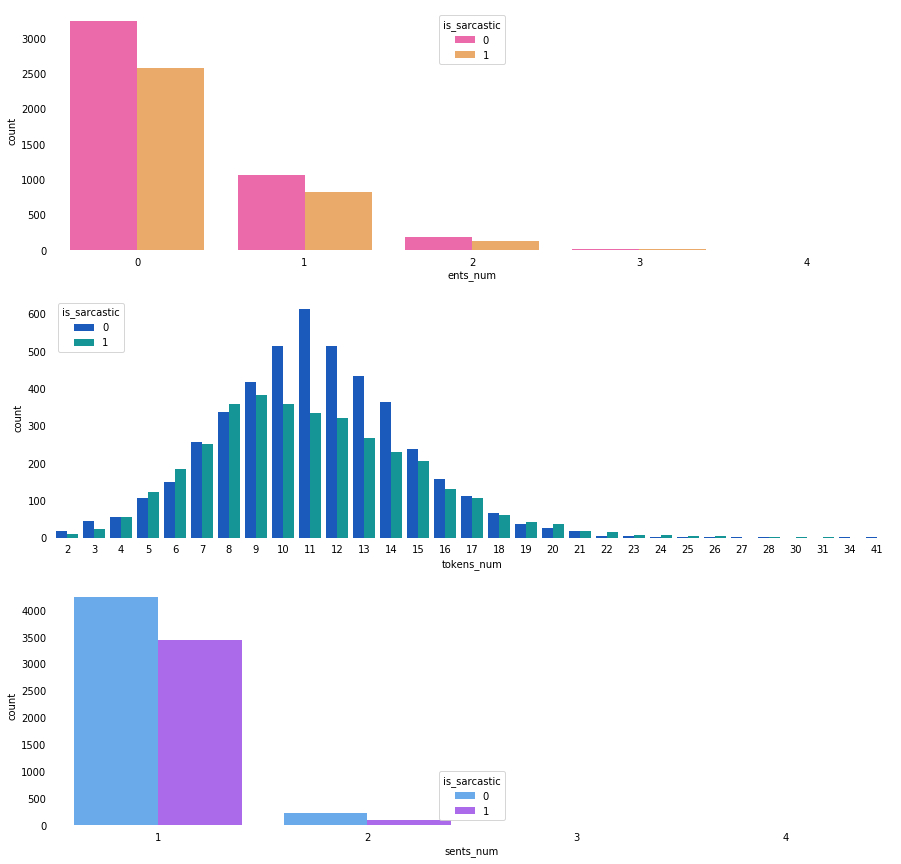

In [262]:
fig,(ax,ax1,ax2)=plt.subplots(nrows=3,ncols=1,figsize=(15,15))
sns.countplot(x='ents_num',data=data_sample,hue='is_sarcastic',ax=ax,palette='spring')
sns.countplot(x='tokens_num',data=data_sample,hue='is_sarcastic',ax=ax1,palette='winter')
sns.countplot(x='sents_num',data=data_sample,hue='is_sarcastic',ax=ax2,palette='cool')

**Building Text Classification Model**

In [263]:
data_sample.drop(['article_link','ents_num','tokens_num','sents_num'],axis=1,inplace=True)
data.drop(['article_link'],axis=1,inplace=True)

In [264]:
blanks = []
for i,he,is_sa in data_sample.itertuples():
    if type(he) == str:
        if he.isspace():
            blanks.append(i)
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


In [265]:
#train_test_split
X = data_sample['headline']
y = data_sample['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [266]:
#Building a pipeline
#Naive Bayes
classifier_nb = Pipeline([('tfidf',TfidfVectorizer()),
                     ('clf',MultinomialNB())])

#Logistic regression
classifier_lr = Pipeline([('tfidf',TfidfVectorizer()),
                     ('clf',LogisticRegression(solver='saga'))])

#Random Forest
classifier_rf = Pipeline([('tfidf',TfidfVectorizer()),
                     ('clf',RandomForestClassifier(bootstrap= False, criterion= 'entropy', n_estimators= 100))])

#Linear SVC
classifier_svc = Pipeline([('tfidf',TfidfVectorizer()),
                     ('clf',LinearSVC())])

In [267]:
#Feeding the data
classifier_nb.fit(X_train,y_train)
classifier_lr.fit(X_train,y_train)
classifier_rf.fit(X_train,y_train)
classifier_svc.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

## Naive Bayes - Predicting and Analyzing the result

In [268]:
#Predicting 
y_pred = classifier_nb.predict(X_test)
yt_pred = classifier_nb.predict(X_train)
#Analyzing
cm = confusion_matrix(y_test,y_pred)
print(f'Confusion Matrix :\n {cm}\n')
print(f'Test Set Accuracy Score :\n {accuracy_score(y_test,y_pred)}\n')
print(f'Train Set Accuracy Score :\n {accuracy_score(y_train,yt_pred)}\n')
print(f'Classification Report :\n {classification_report(y_test,y_pred)}')

Confusion Matrix :
 [[1375   96]
 [ 502  672]]

Test Set Accuracy Score :
 0.7739130434782608

Train Set Accuracy Score :
 0.9359165424739195

Classification Report :
               precision    recall  f1-score   support

           0       0.73      0.93      0.82      1471
           1       0.88      0.57      0.69      1174

   micro avg       0.77      0.77      0.77      2645
   macro avg       0.80      0.75      0.76      2645
weighted avg       0.80      0.77      0.76      2645



## Logistic Regression - Predicting and Analyzing the result

In [269]:
#Predicting 
y_pred = classifier_lr.predict(X_test)
yt_pred = classifier_lr.predict(X_train)
#Analyzing
cm = confusion_matrix(y_test,y_pred)
print(f'Confusion Matrix :\n {cm}\n')
print(f'Test Set Accuracy Score :\n {accuracy_score(y_test,y_pred)}\n')
print(f'Train Set Accuracy Score :\n {accuracy_score(y_train,yt_pred)}\n')
print(f'Classification Report :\n {classification_report(y_test,y_pred)}')

Confusion Matrix :
 [[1247  224]
 [ 272  902]]

Test Set Accuracy Score :
 0.812476370510397

Train Set Accuracy Score :
 0.9316318926974665

Classification Report :
               precision    recall  f1-score   support

           0       0.82      0.85      0.83      1471
           1       0.80      0.77      0.78      1174

   micro avg       0.81      0.81      0.81      2645
   macro avg       0.81      0.81      0.81      2645
weighted avg       0.81      0.81      0.81      2645



## Random Forest - Predicting and Analyzing the result

In [270]:
y_pred = classifier_rf.predict(X_test)
yt_pred = classifier_rf.predict(X_train)

cm = confusion_matrix(y_test,y_pred)
print(f'Confusion Matrix :\n {cm}\n')
print(f'Test Set Accuracy Score :\n {accuracy_score(y_test,y_pred)}\n')
print(f'Train Set Accuracy Score :\n {accuracy_score(y_train,yt_pred)}\n')
print(f'Classification Report :\n {classification_report(y_test,y_pred)}')

Confusion Matrix :
 [[1197  274]
 [ 293  881]]

Test Set Accuracy Score :
 0.7856332703213611

Train Set Accuracy Score :
 1.0

Classification Report :
               precision    recall  f1-score   support

           0       0.80      0.81      0.81      1471
           1       0.76      0.75      0.76      1174

   micro avg       0.79      0.79      0.79      2645
   macro avg       0.78      0.78      0.78      2645
weighted avg       0.79      0.79      0.79      2645



## Linear SVC - Predicting and Analyzing the result

In [271]:
y_pred = classifier_svc.predict(X_test)
yt_pred = classifier_svc.predict(X_train)

cm = confusion_matrix(y_test,y_pred)
print(f'Confusion Matrix :\n {cm}\n')
print(f'Test Set Accuracy Score :\n {accuracy_score(y_test,y_pred)}\n')
print(f'Train Set Accuracy Score :\n {accuracy_score(y_train,yt_pred)}\n')
print(f'Classification Report :\n {classification_report(y_test,y_pred)}')

Confusion Matrix :
 [[1205  266]
 [ 257  917]]

Test Set Accuracy Score :
 0.8022684310018904

Train Set Accuracy Score :
 0.9972056631892697

Classification Report :
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1471
           1       0.78      0.78      0.78      1174

   micro avg       0.80      0.80      0.80      2645
   macro avg       0.80      0.80      0.80      2645
weighted avg       0.80      0.80      0.80      2645

